In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from sklearn.multioutput import MultiOutputRegressor


In [4]:
import glob
import os

# Data Loading

In [5]:
from pathlib import Path

# Check if /kaggle/input exists to determine if running on Kaggle
if os.path.exists("/kaggle/input"):
    # On Kaggle notebook
    DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
else:
    # On local PC
    DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder
train_input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
train_output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))

print(f'Input files: {len(train_input_files)}')
print(f'Output files: {len(train_output_files)}')

Input files: 18
Output files: 18


# Data Preprocessing & Feature Engineering

In [6]:
# --- 1. Load and combine data ---
input_dfs = []
output_dfs = []

for input_file, output_file in zip(train_input_files, train_output_files):
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    input_dfs.append(input_df)
    output_dfs.append(output_df)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f'Raw train input shape: {train_input.shape}')
print(f'Raw train output shape: {train_output.shape}')

Raw train input shape: (4880579, 23)
Raw train output shape: (562936, 6)


In [7]:
# --- 2. Standardize Play Direction (Input Data) ---
print("Standardizing play direction on train_input...")
left_mask_input = train_input['play_direction'] == 'left'

# Flip x coordinates (120 yard field)
train_input.loc[left_mask_input, 'x'] = 120.0 - train_input.loc[left_mask_input, 'x']
train_input.loc[left_mask_input, 'ball_land_x'] = 120.0 - train_input.loc[left_mask_input, 'ball_land_x']
# Flip y coordinates (53.3 yard field width)
train_input.loc[left_mask_input, 'y'] = 53.3 - train_input.loc[left_mask_input, 'y']
train_input.loc[left_mask_input, 'ball_land_y'] = 53.3 - train_input.loc[left_mask_input, 'ball_land_y']
# Flip orientation and direction angles
train_input.loc[left_mask_input, 'o'] = (train_input.loc[left_mask_input, 'o'] + 180) % 360
train_input.loc[left_mask_input, 'dir'] = (train_input.loc[left_mask_input, 'dir'] + 180) % 360

print("Input play direction standardized.")

Standardizing play direction on train_input...
Input play direction standardized.


In [8]:
# --- 3. Run Feature Engineering (New Functions) ---

# Define the new feature engineering functions
def create_advanced_features(df):
    """Create comprehensive feature set for optimal prediction"""
    df = df.copy()

    # Ball-related features
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 +
        (df['y'] - df['ball_land_y'])**2
    )

    df['angle_to_ball'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )

    df['angle_to_ball_deg'] = np.degrees(df['angle_to_ball'])

    df['speed_to_ball'] = df['s'] * np.cos(
        np.radians(df['dir']) - df['angle_to_ball']
    )

    df['delta_x_to_ball'] = df['ball_land_x'] - df['x']
    df['delta_y_to_ball'] = df['ball_land_y'] - df['y']
    df['manhattan_dist_to_ball'] = np.abs(df['delta_x_to_ball']) + np.abs(df['delta_y_to_ball'])
    df['eucl_dist_to_ball'] = np.sqrt((df['ball_land_x'] - df['x'])**2 + (df['ball_land_y'] - df['y'])**2)
    df['x_y_dist_ratio'] = np.abs(df['delta_x_to_ball']) / (np.abs(df['delta_y_to_ball']) + 0.1)

    # Role encoding
    role_map = {
        'Targeted Receiver': 4,
        'Defensive Coverage': 3,
        'Other Route Runner': 2,
        'Passer': 1
    }
    df['role_encoded'] = df['player_role'].map(role_map).fillna(0)

    df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
    df['is_targeted'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['is_defender'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(int)

    # Field position
    df['field_position'] = df['absolute_yardline_number']
    df['play_dir_encoded'] = (df['play_direction'] == 'right').astype(int)

    df['dist_from_left_sideline'] = df['y']
    df['dist_from_right_sideline'] = 53.3 - df['y']
    df['dist_from_nearest_sideline'] = np.minimum(
        df['dist_from_left_sideline'],
        df['dist_from_right_sideline']
    )
    df['dist_from_endzone'] = np.minimum(df['x'], 120 - df['x'])

    # Velocity and acceleration components
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    df['ax'] = df['a'] * np.cos(np.radians(df['dir']))
    df['ay'] = df['a'] * np.sin(np.radians(df['dir']))
    df['speed_squared'] = df['s'] ** 2
    df['accel_squared'] = df['a'] ** 2

    # Orientation features
    df['orientation_dir_diff'] = np.abs(df['o'] - df['dir'])
    df['orientation_dir_diff'] = np.where(
        df['orientation_dir_diff'] > 180,
        360 - df['orientation_dir_diff'],
        df['orientation_dir_diff']
    )
    df['facing_ball'] = (df['orientation_dir_diff'] < 90).astype(int)

    # Physics-based features
    df['expected_time_to_ball'] = df['dist_to_ball_land'] / (df['s'] + 0.1)
    df['frames_after_ball'] = df['num_frames_output'] - (df['expected_time_to_ball'] * 10)

    df['estimated_x_next'] = df['x'] + df['vx'] * 0.1
    df['estimated_y_next'] = df['y'] + df['vy'] * 0.1
    df['estimated_x_1sec'] = df['x'] + df['vx']
    df['estimated_y_1sec'] = df['y'] + df['vy']

    df['can_reach_ball'] = (df['expected_time_to_ball'] < df['num_frames_output'] * 0.1).astype(int)

    # Kinetic energy proxy
    df['kinetic_energy'] = 0.5 * df['speed_squared']

    # Trajectory curvature proxy
    df['velocity_angle'] = np.arctan2(df['vy'], df['vx'])
    df['trajectory_alignment'] = np.abs(df['velocity_angle'] - df['angle_to_ball'])

    return df
     
def add_sequence_features(df, window=3):
    """Add temporal sequence features"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    # Velocity changes
    df['delta_vx'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vx'].diff()
    df['delta_vy'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vy'].diff()
    df['delta_speed'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].diff()

    # Acceleration changes (jerk)
    df['delta_ax'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ax'].diff()
    df['delta_ay'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ay'].diff()

    # Rolling statistics
    for col in ['s', 'a', 'vx', 'vy']:
        df[f'{col}_rolling_mean'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{col}_rolling_std'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    df.fillna(0, inplace=True)

    return df
     
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    print("Starting advanced feature creation...")
    df = create_advanced_features(df)
    print("Starting sequence feature creation...")
    df = add_sequence_features(df)
    print("Feature engineering complete.")
    return df

# Apply the functions
engineered_df = engineer_features(train_input)

Starting advanced feature creation...
Starting sequence feature creation...
Feature engineering complete.


In [9]:
# --- 4. Filter for players to predict ---
players2predict = engineered_df[engineered_df["player_to_predict"] == True].copy()
print(f'Filtered engineered data shape: {players2predict.shape}')

# --- 5. Merge with output data ---
merged = players2predict.merge(
    train_output,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    suffixes=("_input", "_output") # This renames 'x' to 'x_input', 'y' to 'y_input'
)
print(f'Merged data shape: {merged.shape}')

# --- 6. Standardize Target (Output) Coordinates ---
print("Standardizing output (target) coordinates...")
left_mask_merged = merged['play_direction'] == 'left'
merged.loc[left_mask_merged, 'x_output'] = 120.0 - merged.loc[left_mask_merged, 'x_output']
merged.loc[left_mask_merged, 'y_output'] = 53.3 - merged.loc[left_mask_merged, 'y_output']
print("Output coordinates standardized.")

# --- 7. Rename input 'x' and 'y' to match feature list ---
# The merge might not have 'x' in train_output, so suffixes might not apply.
# We explicitly rename to match the feature list.
if 'x' in merged.columns:
    merged = merged.rename(columns={'x': 'x_input', 'y': 'y_input'})
    print("Renamed 'x'/'y' to 'x_input'/'y_input'.")

Filtered engineered data shape: (1303440, 74)
Merged data shape: (560426, 76)
Standardizing output (target) coordinates...
Output coordinates standardized.


# Feature selection 

In [10]:
# --- Start of Feature Finalization ---

# 1. Convert Player Height to Inches
def height_to_inches(h):
    try:
        f, i = str(h).split("-")
        return int(f) * 12 + int(i)
    except:
        return np.nan

merged["player_height"] = merged["player_height"].apply(height_to_inches)

# 2. One-hot encode player_position and player_role
# We save the training dummies to align the test set later
position_dummies_train = pd.get_dummies(merged["player_position"], prefix="position")
role_dummies_train = pd.get_dummies(merged["player_role"], prefix="role")

merged = pd.concat([
    merged,
    position_dummies_train,
    role_dummies_train
], axis=1)

# 3. Define Final Feature List
feature_cols = ['absolute_yardline_number', 'player_weight', 'x_input', 'y_input', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y',
       'dist_to_ball_land', 'angle_to_ball', 'angle_to_ball_deg',
       'speed_to_ball', 'delta_x_to_ball', 'delta_y_to_ball',
       'manhattan_dist_to_ball', 'x_y_dist_ratio',
       'is_offense', 'is_targeted', 'is_defender', 'is_passer',
       'field_position', 'play_dir_encoded', 'dist_from_left_sideline',
       'dist_from_right_sideline', 'dist_from_nearest_sideline',
       'dist_from_endzone', 'vx', 'vy', 'ax', 'ay', 'speed_squared',
       'accel_squared', 'orientation_dir_diff', 'facing_ball',
       'expected_time_to_ball', 'frames_after_ball', 'estimated_x_next',
       'estimated_y_next', 'estimated_x_1sec', 'estimated_y_1sec',
       'can_reach_ball', 'kinetic_energy', 'velocity_angle',
       'trajectory_alignment', 'delta_vx', 'delta_vy', 'delta_speed',
       'delta_ax', 'delta_ay', 's_rolling_mean', 's_rolling_std',
       'a_rolling_mean', 'a_rolling_std', 'vx_rolling_mean', 'vx_rolling_std',
       'vy_rolling_mean', 'vy_rolling_std',
       'player_height' # Added player_height as it's processed
]
# Add all dummy columns
dummy_cols = [c for c in merged.columns if c.startswith(("position_", "role_"))]
feature_cols.extend(dummy_cols)

# Remove potential duplicates
feature_cols = sorted(list(set(feature_cols))) 

# 4. Create X and y
X = merged[feature_cols].fillna(0)
y = merged[["x_output","y_output"]]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (560426, 81)
Target shape: (560426, 2)


# Data Split for training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target shape: {y_train.shape} (samples, [x, y])')

Training set size: 392298
Test set size: 168128
Target shape: (392298, 2) (samples, [x, y])


# Model Training

In [12]:
boost_nfl = GBR(n_estimators=100,       ### 5000
                   learning_rate=0.3,  ## 0.001
                   max_depth=3,
                   random_state=0)
multi_output_booster = MultiOutputRegressor(estimator=boost_nfl)
multi_output_booster.fit(X_train, y_train)


,estimator,GradientBoost...andom_state=0)
,n_jobs,None
,loss,'squared_error'
,learning_rate,0.3
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3


# Model Evaluation : Assessing Test and Training Data

In [18]:
# Predict on training and test data
y_hat_train = multi_output_booster.predict(X_train)
y_hat_test = multi_output_booster.predict(X_test)

# Calculate MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Test Mean Squared Error (MSE): {test_mse}")

# You can also calculate MSE per output (x and y)
train_mse_x = mean_squared_error(y_train.iloc[:, 0], y_hat_train[:, 0])
train_mse_y = mean_squared_error(y_train.iloc[:, 1], y_hat_train[:, 1])
test_mse_x = mean_squared_error(y_test.iloc[:, 0], y_hat_test[:, 0])
test_mse_y = mean_squared_error(y_test.iloc[:, 1], y_hat_test[:, 1])

print(f"\nTest MSE for X: {test_mse_x}")
print(f"Test MSE for Y: {test_mse_y}")

Training Mean Squared Error (MSE): 13.184169046626842
Test Mean Squared Error (MSE): 13.42672798984523

Test MSE for X: 13.32184972041629
Test MSE for Y: 13.53160625927417


# Importance of features

In [19]:
# 1. Extract the feature importances from each fitted model inside the wrapper
all_importances = [
    estimator.feature_importances_ for estimator in multi_output_booster.estimators_
]

# 2. Average the importances across all models
# axis=0 calculates the mean down each column
average_importances = np.mean(all_importances, axis=0)

# 3. Create the DataFrame using the averaged importances
feature_names = X_train.columns.tolist()
feature_imp = pd.DataFrame(
    {'importance': average_importances},
    index=feature_names
)

# 4. Sort and display the results
print(feature_imp.sort_values(by='importance', ascending=False))

                  importance
ball_land_y         0.400659
estimated_x_next    0.260119
ball_land_x         0.181463
estimated_y_next    0.040395
x_input             0.034716
...                      ...
position_DT         0.000000
play_dir_encoded    0.000000
kinetic_energy      0.000000
is_passer           0.000000
a                   0.000000

[81 rows x 1 columns]


In [20]:
y_hat_boost = multi_output_booster.predict(X_test)

mse = np.mean((y_test - y_hat_boost)**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 13.42672798984523


# Data Visualisation of One tree

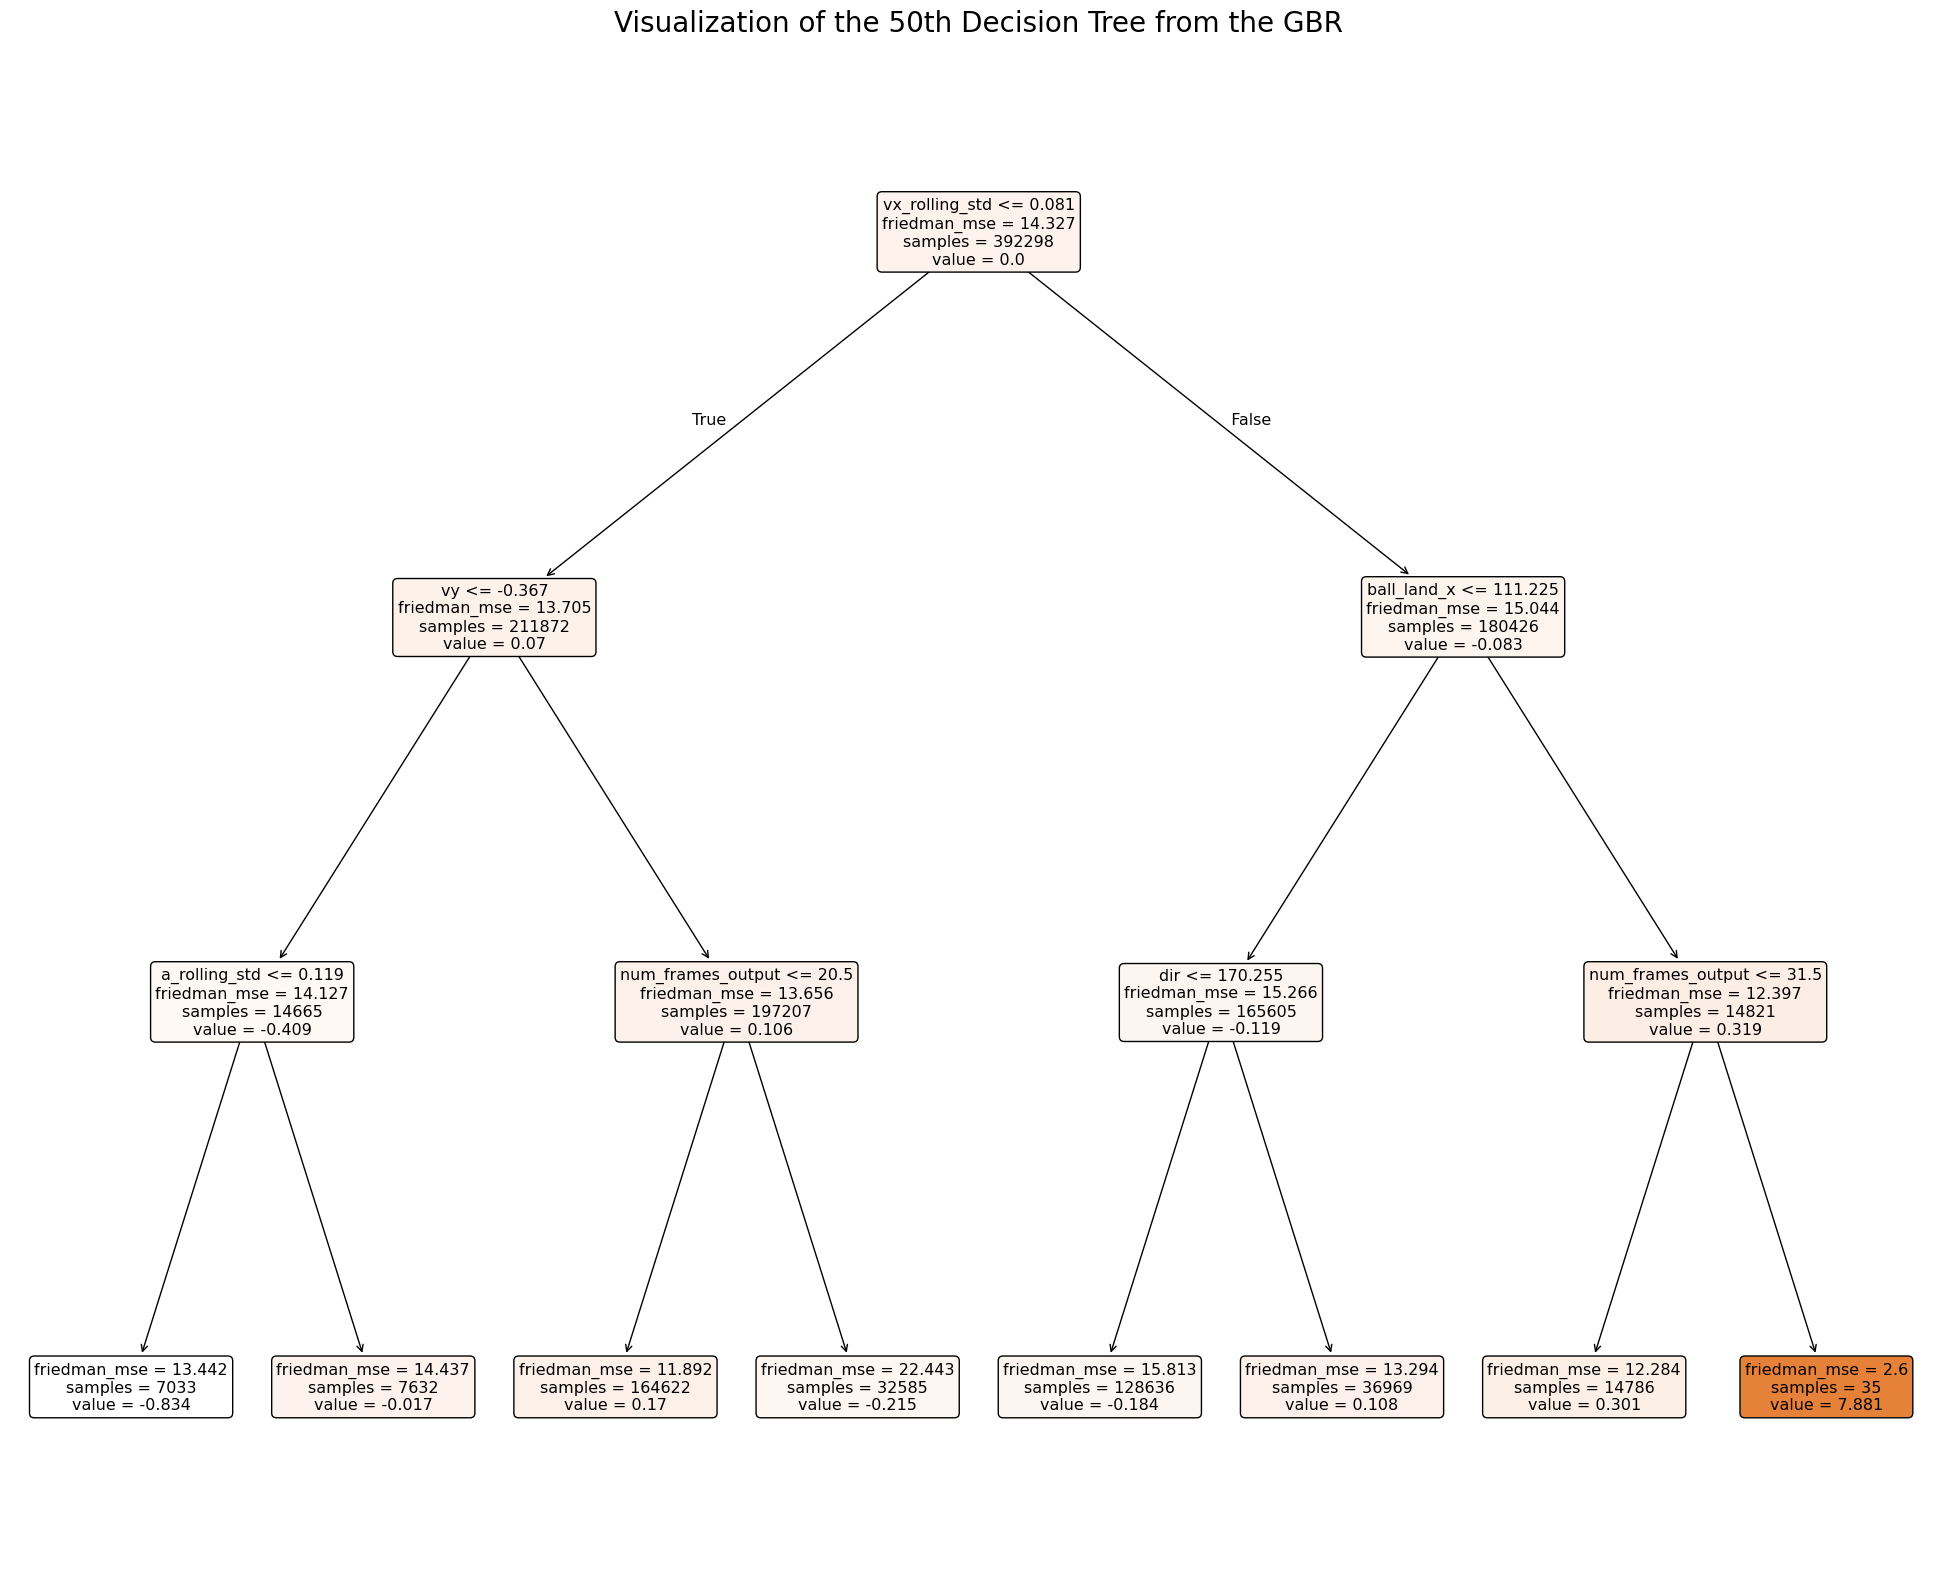

In [21]:
# 1. Select the GBR model for the first output variable
gbr_for_first_output = multi_output_booster.estimators_[0]

# 2. Pick one of the simple trees from the GBR's sequence.
#    Let's pick the 50th tree (index 49). Early trees are often less interesting.
single_tree_from_gbr = gbr_for_first_output.estimators_[49][0]

# 3. Now, plot this single tree
plt.figure(figsize=(25, 20))
plot_tree(single_tree_from_gbr,
          feature_names=feature_names,
          filled=True,
          rounded=True)

plt.title("Visualization of the 50th Decision Tree from the GBR", fontsize=20)
plt.show()

# Submission

In [ ]:
# %%
# --- Imports and API setup ---
import os
import pandas as pd
import polars as pl
import sys
from pathlib import Path

# 1. Add the evaluation API to the system path
# (Uses the DATA_DIR variable you defined in your "Data Loading" cell)
EVAL_DIR = DATA_DIR / 'kaggle_evaluation'
if str(EVAL_DIR) not in sys.path:
    sys.path.append(str(EVAL_DIR))

# Now these imports will work
import kaggle_evaluation.nfl_inference_server

# --- Prediction Function ---

# The helper functions (create_advanced_features, add_sequence_features, 
# engineer_features, height_to_inches) and the global variables
# (multi_output_booster, feature_cols) are already defined in the notebook's
# global scope and will be available to this function.

def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame | pd.DataFrame:
    """
    Generates predictions for the test set.
    This function is called by the evaluation API and must return a
    DataFrame in the submission format.
    
    It uses the globally defined:
    - 'engineer_features' (and its helpers)
    - 'height_to_inches'
    - 'multi_output_booster' (the trained model)
    - 'feature_cols' (the list of features to use)
    """
    print("API: Received prediction request...")
    
    # --- Convert Polars to Pandas ---
    test_input_df = test_input.to_pandas()
    test_df = test.to_pandas()
    
    # --- 1. Standardize Play Direction (Input) ---
    print("API: Standardizing play direction...")
    left_mask_test = test_input_df['play_direction'] == 'left'
    
    test_input_df.loc[left_mask_test, 'x'] = 120.0 - test_input_df.loc[left_mask_test, 'x']
    test_input_df.loc[left_mask_test, 'ball_land_x'] = 120.0 - test_input_df.loc[left_mask_test, 'ball_land_x']
    test_input_df.loc[left_mask_test, 'y'] = 53.3 - test_input_df.loc[left_mask_test, 'y']
    test_input_df.loc[left_mask_test, 'ball_land_y'] = 53.3 - test_input_df.loc[left_mask_test, 'ball_land_y']
    test_input_df.loc[left_mask_test, 'o'] = (test_input_df.loc[left_mask_test, 'o'] + 180) % 360
    test_input_df.loc[left_mask_test, 'dir'] = (test_input_df.loc[left_mask_test, 'dir'] + 180) % 360
    
    # --- 2. Feature Engineering ---
    print("API: Performing feature engineering...")
    # (This calls create_advanced_features and add_sequence_features)
    engineered_test_df = engineer_features(test_input_df)
    
    # --- 3. Filter for players to predict ---
    players2predict_test = engineered_test_df[engineered_test_df["player_to_predict"] == True].copy()
    
    # --- 4. Final Feature Prep ---
    
    # Rename 'x' and 'y' to match feature_cols list
    if 'x' in players2predict_test.columns:
        players2predict_test = players2predict_test.rename(columns={'x': 'x_input', 'y': 'y_input'})

    # Convert player_height to numeric
    players2predict_test['player_height'] = players2predict_test['player_height'].apply(height_to_inches)
    
    # One-hot encode player_position and player_role
    test_position_dummies = pd.get_dummies(players2predict_test['player_position'], prefix='position')
    test_role_dummies = pd.get_dummies(players2predict_test['player_role'], prefix='role')
    
    test_features = pd.concat([players2predict_test, test_position_dummies, test_role_dummies], axis=1)

    # --- 5. Align Columns with Training Data ---
    print("API: Aligning feature columns...")
    
    # Create an empty DataFrame with the exact training columns
    # 'feature_cols' is from the global scope
    X_test_api = pd.DataFrame(columns=feature_cols)
    
    # Concatenate. This adds all columns from test_features.
    X_test_api = pd.concat([X_test_api, test_features])
    
    # Select *only* the training columns (handles new/missing dummies) and fill NaNs
    X_test_api = X_test_api[feature_cols].fillna(0)
    
    print(f'API: Test features shape: {X_test_api.shape}')

    # --- 6. Predict on test data ---
    print('API: Predicting test data...')
    # Uses the globally trained 'multi_output_booster'
    test_predictions = multi_output_booster.predict(X_test_api)
    test_pred_x = test_predictions[:, 0]
    test_pred_y = test_predictions[:, 1]
    
    # Add predictions back to the filtered test dataframe
    players2predict_test['pred_x'] = test_pred_x
    players2predict_test['pred_y'] = test_pred_y

    # --- 7. Invert predictions for 'left' plays ---
    print("API: Inverting predictions for 'left' plays...")
    # We must use the 'play_direction' from the filtered test set
    left_mask_pred = players2predict_test['play_direction'] == 'left'
    
    players2predict_test.loc[left_mask_pred, 'pred_x'] = 120.0 - players2predict_test.loc[left_mask_pred, 'pred_x']
    players2predict_test.loc[left_mask_pred, 'pred_y'] = 53.3 - players2predict_test.loc[left_mask_pred, 'pred_y']
    print("API: Inversion complete.")

    # --- 8. Format the submission ---
    submission = test_df.copy()
    
    # Merge predictions
    test_pred_df = players2predict_test[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].copy()
    
    submission = submission.merge(
        test_pred_df,
        on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
        how='left'
    )
    
    # Return *only* 'x' and 'y' columns
    predictions_df = submission[['pred_x', 'pred_y']].rename(columns={'pred_x': 'x', 'pred_y': 'y'})
    
    # Fill any NaNs (for players not in 'player_to_predict')
    predictions_df = predictions_df.fillna(0)
    
    print("API: Prediction request complete.")
    
    # Check assertions
    assert isinstance(predictions_df, (pd.DataFrame, pl.DataFrame))
    assert len(predictions_df) == len(test_df)
    
    # Return the DataFrame with *only* x and y
    return predictions_df

# --- Server Setup ---
# This code sets up and runs the server
inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("Starting server for competition reruns...")
    inference_server.serve()
else:
    # This runs the local gateway for testing
    print("Running local gateway for testing...")
    inference_server.run_local_gateway((f'{DATA_DIR}',)) # Pass the DATA_DIR as the path

print("Submission process finished.")

Running local gateway for testing...
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (45, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays back to original coordinates...
API: Inversion complete.
API: Prediction request complete.
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (66, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays back to original coordinates...
API: Inversion complete.
API: Prediction request complete.
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (84, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays b